In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.4/756.4 kB 4.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
from PIL import Image
import numpy as np

In [ ]:
from ultralytics import YOLO

Translasi Citra via transformasi rigid

In [ ]:
def get_center_point(image_paths, model_path='/content/Deteksi_landmark_v3.pt'):
    # Load a pretrained YOLOv8n model
    model = YOLO(model_path)

    # Run the model on the provided images
    results = model(image_paths)  # return a list of Results objects

    # Extract boxes from the first result
    # buat mengambil koordinat bounding box
    boxes = results[0].boxes.xywh

    # Menghitung titik tengah
    x_center = boxes[:, 0] + boxes[:, 2] / 2
    y_center = boxes[:, 1] + boxes[:, 3] / 2

    # Return the center points as a tensor
    return x_center, y_center

In [ ]:
def fill_cbct_array(ct_path, x_trans, y_trans):
    ct_image = Image.open(ct_path) #baca gambarnya
    ct_arr = np.array(ct_image) #mengambil data array gambarnya
    ct_new = np.zeros((384, 384)) #array kosong

    y = int(y_trans.item()) #tensor menjadi integer
    for i in range(384):
        x = int(x_trans.item())
        for j in range(384):
            ct_new[i][j] = ct_arr[y][x]
            x += 1
        y += 1

    return ct_new

In [ ]:
#Menentukan titik tengah ct dan cbct sebagai titik translasi
ct_center_point = get_center_point('/content/178ct.png')
cbct_center_point = get_center_point('/content/178cbct.png')


image 1/1 /content/178ct.png: 640x640 1 backbone, 4247.6ms
Speed: 4.3ms preprocess, 4247.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/178cbct.png: 640x640 1 backbone, 5507.1ms
Speed: 6.8ms preprocess, 5507.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


In [ ]:
#menampilkan nilai titik tengah ct
ct_center_point

(tensor([276.5019]), tensor([291.8239]))

In [ ]:
#menampilkan nilai titik tengah cbct
cbct_center_point

(tensor([211.6774]), tensor([229.9944]))

In [ ]:
#untuk mendapatkan titik tengah baru, titik tengahnya x ct - x cbct, dan y ct - y cbct
x_trans = ct_center_point[0] - cbct_center_point[0]
y_trans = ct_center_point[1] - cbct_center_point[1]

In [ ]:
#hasil translasi ke sumbu-x (masih dalam pixel)
x_trans

tensor([64.8245])

In [ ]:
#hasil translasi ke sumbu y
y_trans

tensor([61.8295])

In [ ]:
#konversi pixel ke cm, dengan DPI = 96
def pixels_to_cm(pixels, dpi):
    """
    Fungsi untuk mengonversi ukuran dalam pixels ke sentimeter berdasarkan DPI.

    Args:
    pixels: int atau float, jumlah pixels yang ingin dikonversi.
    dpi: int atau float, dots per inch dari gambar.

    Returns:
    float, ukuran dalam sentimeter.
    """
    inches = pixels / dpi  # Mengonversi pixels ke inches
    cm = inches * 2.54     # Mengonversi inches ke centimeter
    return cm

# Contoh penggunaan
pixels = 17.1109  # jumlah pixel yang ingin dikonversi
dpi = 96      # resolusi gambar dalam DPI

# Mengonversi pixels ke cm
cm_size = pixels_to_cm(pixels, dpi)
print(f"{pixels} pixels adalah {cm_size:.2f} cm pada {dpi} DPI.")


17.1109 pixels adalah 0.45 cm pada 96 DPI.


In [ ]:
ct_new = fill_cbct_array('/content/178ct.png', x_trans, y_trans) #diupload gambar ct

In [ ]:
ct_new

array([[          2,           2,           2, ...,           2,           2,           2],
       [          2,           2,           2, ...,           2,           2,           2],
       [          2,           2,           2, ...,           2,           2,           2],
       ...,
       [          2,           2,           2, ...,           2,           2,           2],
       [          2,           2,           2, ...,           2,           2,           2],
       [          2,           2,           2, ...,           2,           2,           2]])

In [ ]:
#Menyimpan gambar dalam format png
import cv2
# Convert array to uint8 (assuming the array values are in the range 0-255)
image_array = ct_new.astype(np.uint8)

# Save the image using OpenCV
file_path = "regis178.png"  # Change the file extension based on your desired format
cv2.imwrite(file_path, image_array)

print(f"Image saved to: {file_path}")


Image saved to: regis178.png


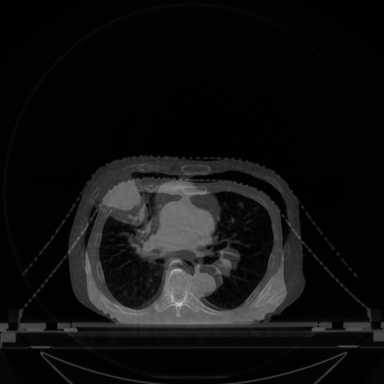

In [ ]:
#Melihat overlay citra hasil registrasi dan cbct
import cv2
from skimage import io
from skimage.transform import resize
import numpy as np

# Path ke citra CBCT dan citra rigid
path_1 = "/content/496cbct.png"  # CBCT
path_2 = "/content/regis496.png"  # Rigid

# Membaca citra CBCT dan citra rigid
cbct = io.imread(path_1)
rigid = io.imread(path_2)

# Resize citra menjadi ukuran yang sama
cbct_resized = resize(cbct, (384, 384, 3))
rigid_resized = resize(rigid, (384, 384, 3))

# Mengonversi citra menjadi tipe data uint8
cbct_resized_uint8 = (cbct_resized * 255).astype('uint8')
rigid_resized_uint8 = (rigid_resized * 255).astype('uint8')

# Mengonversi citra menjadi citra grayscale
cbct_grayscale = cv2.cvtColor(cbct_resized_uint8, cv2.COLOR_RGB2GRAY)
rigid_grayscale = cv2.cvtColor(rigid_resized_uint8, cv2.COLOR_RGB2GRAY)

# Mengonversi citra grayscale menjadi citra RGB dengan saluran warna yang sama
cbct_rgb = cv2.cvtColor(cbct_grayscale, cv2.COLOR_GRAY2RGB)
rigid_rgb = cv2.cvtColor(rigid_grayscale, cv2.COLOR_GRAY2RGB)

# Menumpukkan kedua citra
overlay = cv2.addWeighted(cbct_rgb, 0.5, rigid_rgb, 0.5, 0)

# Menampilkan citra yang ditumpuk
from google.colab.patches import cv2_imshow
cv2_imshow(overlay)

In [ ]:
# Menyimpan output gambar
output_path = "/content/overlay_result.png"  # Path untuk menyimpan output gambar
cv2.imwrite(output_path, overlay)
print("Overlay result saved at:", output_path)

Overlay result saved at: /content/overlay_result.png


Point Matching Evaluation (digunakan untuk mengevaluasi titik yang mirip pada dua citra)

In [ ]:
#Menampilkan titik-titik yang saling berkorespondensi dan mengekstraknya menggunakan algoritma ORB
import numpy as np
import cv2 as cv

def euclidean_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

# Mengupload gambar untuk mengekstrak keypoint
img1 = cv.imread('/content/regis496.png', cv.IMREAD_GRAYSCALE) #hasil registrasi
img2 = cv.imread('/content/496cbct.png', cv.IMREAD_GRAYSCALE) #cbct

orb = cv.ORB_create()
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# Create BFMatcher object and match descriptors
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

# Menghitung titik tengah citra via spinal cord
ct_center_point = get_center_point('/content/regis496.png')
cbct_center_point = get_center_point('/content/496cbct.png')

# Set maximum allowed distance between keypoints
max_distance = 30

# Find closest matches to the center of the images with distance less than max_distance
closest_matches_ct = [match for match in matches if euclidean_distance(kp1[match.queryIdx].pt, ct_center_point) < max_distance]
closest_matches_cbct = [match for match in matches if euclidean_distance(kp2[match.trainIdx].pt, cbct_center_point) < max_distance]

# Sort matches based on distance from the center
closest_matches_ct = sorted(closest_matches_ct, key=lambda x: euclidean_distance(kp1[x.queryIdx].pt, ct_center_point))[:3]
closest_matches_cbct = sorted(closest_matches_cbct, key=lambda x: euclidean_distance(kp2[x.trainIdx].pt, cbct_center_point))[:3]

# Convert closest matches to keypoints
closest_kp_ct = [kp1[match.queryIdx] for match in closest_matches_ct]
closest_kp_cbct = [kp2[match.trainIdx] for match in closest_matches_cbct]

print("Closest keypoints in image 1:")
for i, kp in enumerate(closest_kp_ct, 1):
    print("Keypoint {}: ({}, {})".format(i, kp.pt[0], kp.pt[1]))

print("\nClosest keypoints in image 2:")
for i, kp in enumerate(closest_kp_cbct, 1):
    print("Keypoint {}: ({}, {})".format(i, kp.pt[0], kp.pt[1]))




image 1/1 /content/regis496.png: 640x640 1 backbone, 4785.1ms
Speed: 3.9ms preprocess, 4785.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/496cbct.png: 640x640 1 backbone, 4455.3ms
Speed: 4.4ms preprocess, 4455.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Closest keypoints in image 1:
Keypoint 1: (201.60000610351562, 298.8000183105469)
Keypoint 2: (204.0422821044922, 298.5984802246094)
Keypoint 3: (180.0, 305.0)

Closest keypoints in image 2:
Keypoint 1: (184.32000732421875, 303.84002685546875)
Keypoint 2: (205.0, 294.0)
Keypoint 3: (209.01893615722656, 293.621826171875)


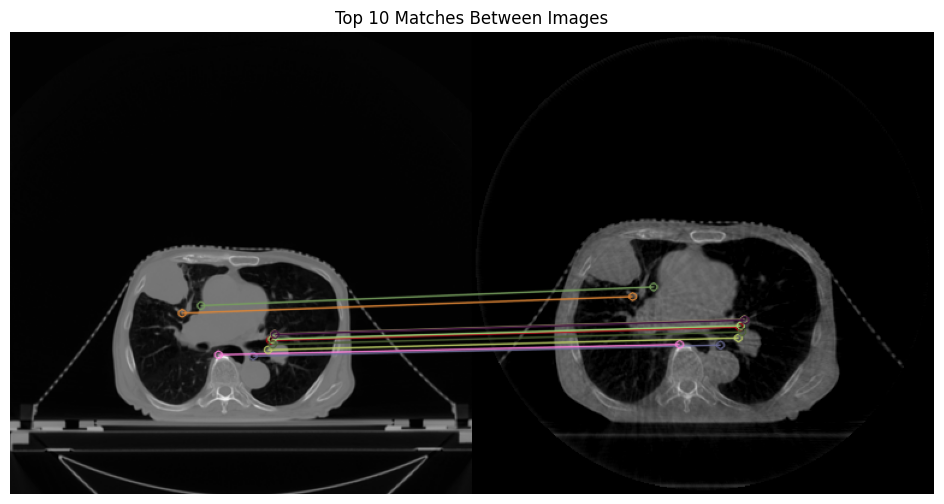

In [ ]:
#menampilkan gambar titik-titik yang sama pada dua citra
import matplotlib.pyplot as plt

# Draw matches
img_matches = cv.drawMatches(img1, kp1, img2, kp2, matches[:10], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Convert OpenCV BGR image to RGB for plotting with matplotlib
img_matches_rgb = cv.cvtColor(img_matches, cv.COLOR_BGR2RGB)

# Plot matches
plt.figure(figsize=(12, 6))
plt.imshow(img_matches_rgb)
plt.title('Top 10 Matches Between Images')
plt.axis('off')
plt.show()


In [ ]:
#Menghitung nilai point matching berdasarkan 3 titik yang saling berkorespondensi
import numpy as np

# Keypoints citra registrasi
keypoints_img1 = np.array([[[201.60000610351562, 298.8000183105469]], [[204.0422821044922, 298.5984802246094]], [[180.0, 305.0]]])

# Keypoints citra cbct
keypoints_img2 = np.array([[[184.32000732421875, 303.84002685546875]], [[205.0, 294.0]], [[209.01893615722656, 293.621826171875]]])

# Hitung selisih antara titik pada citra 1 dan citra 2
difference = keypoints_img1 - keypoints_img2

# Hitung kuadrat dari selisih
squared_difference = difference ** 2

# Hitung jumlah kuadrat selisih untuk setiap titik
sum_squared_difference = np.sum(squared_difference, axis=1)

# Hitung nilai R
R = np.sqrt(np.sum(sum_squared_difference) / len(keypoints_img1))

print("Nilai R:", R)


Nilai R: 20.957296130060183


DSC Metric Evaluation

In [ ]:
!pip install ultralytics
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 8.7 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
from torchmetrics.classification import Dice

In [ ]:
seg_model = YOLO('/content/Model_Segmentasi.pt')

In [ ]:
fixed_img = seg_model("/content/178cbct.png") #cbct
moving_img = seg_model("/content/regis178.png") #hasil registrasi


image 1/1 /content/178cbct.png: 640x640 3 bones, 323.0ms
Speed: 4.8ms preprocess, 323.0ms inference, 18.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/regis178.png: 640x640 1 bone, 268.8ms
Speed: 3.7ms preprocess, 268.8ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)


In [ ]:
mask1 = fixed_img[0].masks.cpu().data.long()
mask2 = moving_img[0].masks.cpu().data.long()

In [ ]:
import matplotlib.pyplot as plt

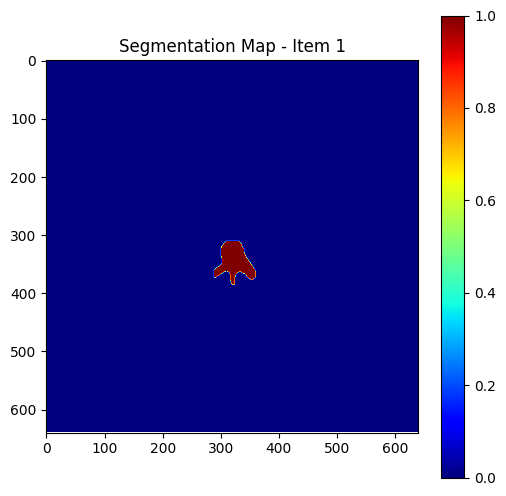

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [ ]:
# Assuming 'segmentation_tensor' contains the segmentation results with shape [5, 384, 384]

# Loop through each item in the batch
for i in range(mask1.shape[0]):
    segmentation_map = mask2[i].cpu().numpy()  # Convert torch tensor to numpy array
    plt.figure(figsize=(6, 6))
    plt.imshow(segmentation_map, cmap='jet')  # Use 'jet' colormap for visualization
    plt.colorbar()
    plt.title(f'Segmentation Map - Item {i+1}')
    plt.show()

In [ ]:
import torchvision

In [ ]:
def dice_cal(mask1, mask2):
  dice = Dice(num_classes=4, average='macro')
  return dice(preds=mask1, target=mask2)

In [ ]:
dsc = dice_cal(mask1, mask2)
print("Dice score:", dsc.item())

ValueError: The `preds` and `target` should have the same first dimension.

Evaluasi Bounding Box pada model deteksi landmark (Intersection Over Union)

In [ ]:
!pip install ultralytics
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 5.3 MB/s eta 0:00:00


In [ ]:
!curl -L "https://app.roboflow.com/ds/14iU79nxKL?key=PFGRF84LY0" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   903  100   903    0     0   3563      0 --:--:-- --:--:-- --:--:--  3569
100 20.5M  100 20.5M    0     0  34.0M      0 --:--:-- --:--:-- --:--:-- 34.0M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/CT-1-2-246-352-63-1-4640428948477580013-13702323763979213732_png.rf.a2f10246ea439d1025ea66fb5b75389e.jpg  
 extracting: test/images/CT-1-2-246-352-63-1-4658839190790665991-888795829363520386_png.rf.8c8f90fc6aa1f4b9cff47fd86afe3a66.jpg  
 extracting: test/images/CT-1-2-246-352-63-1-4661307992931767395-16979408375297691552_png.rf.c3bb7fece35541a8cd6f0cff5722db17.jpg  
 extracting: test/images/CT-1-2-246-352-63-1-4690416492475106294-7590472259270197641_png.rf.f2a8a64aa2ffd76d

In [ ]:
from ultralytics import YOLO
model = YOLO('/content/Deteksi_landmark_v3.pt')  # load a custom model

# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered

RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

In [ ]:
pred = model.predict('/content/CT.1.2.840.113704.1.111.1668.1513237411.44.png', save=True, conf=0.5)


image 1/1 /content/CT.1.2.840.113704.1.111.1668.1513237411.44.png: 640x640 1 backbone, 247.3ms
Speed: 6.6ms preprocess, 247.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict2


In [ ]:
box_1 = pred[0].boxes.xywh
box_1

tensor([[254.0409, 295.8587,  25.0570,  36.9405]])

In [ ]:
import torch
from torchmetrics.detection import IntersectionOverUnion

def xywh_to_xyxy(boxes_xywh):
    # Mengonversi format xywh menjadi xmin, ymin, xmax, ymax
    boxes_xyxy = torch.zeros_like(boxes_xywh)
    boxes_xyxy[:, 0] = boxes_xywh[:, 0] - boxes_xywh[:, 2] / 2  # xmin = x - w / 2
    boxes_xyxy[:, 1] = boxes_xywh[:, 1] - boxes_xywh[:, 3] / 2  # ymin = y - h / 2
    boxes_xyxy[:, 2] = boxes_xywh[:, 0] + boxes_xywh[:, 2] / 2  # xmax = x + w / 2
    boxes_xyxy[:, 3] = boxes_xywh[:, 1] + boxes_xywh[:, 3] / 2  # ymax = y + h / 2
    return boxes_xyxy

pred_boxes = torch.tensor([[254.0409, 295.8587,  25.0570,  36.9405]])
target_boxes = torch.tensor([[254.38, 296.88, 23.75, 28.75]]) #Ground truth dari roboflow

pred_boxes_xyxy = xywh_to_xyxy(pred_boxes)
target_boxes_xyxy = xywh_to_xyxy(target_boxes)

pred = [{"boxes": pred_boxes_xyxy, "labels": torch.tensor([1])}]
target = [{"boxes": target_boxes_xyxy, "labels": torch.tensor([1])}]

metric = IntersectionOverUnion()
iou = metric(pred, target)
print("Intersection over Union (IoU):", iou)

Intersection over Union (IoU): {'iou': tensor(0.7377)}


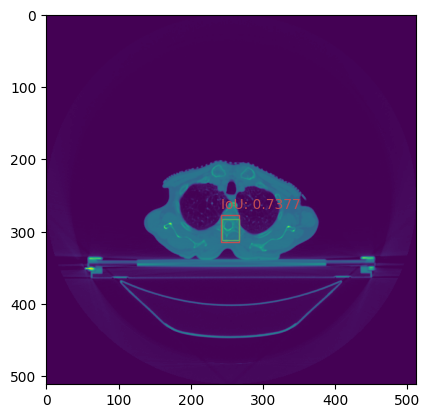

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Load gambar
img_path = '/content/CT.1.2.840.113704.1.111.1668.1513237411.44.png'
image = Image.open(img_path)

# Buat subplot
fig, ax = plt.subplots(1)

# Tampilkan gambar
ax.imshow(image)

# Tambahkan bounding box prediksi
pred_box = pred_boxes_xyxy[0].tolist()
pred_rect = patches.Rectangle((pred_box[0], pred_box[1]), pred_box[2]-pred_box[0], pred_box[3]-pred_box[1], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(pred_rect)


# Tambahkan bounding box ground truth
gt_box = target_boxes_xyxy[0].tolist()
gt_rect = patches.Rectangle((gt_box[0], gt_box[1]), gt_box[2]-gt_box[0], gt_box[3]-gt_box[1], linewidth=1, edgecolor='g', facecolor='none')
ax.add_patch(gt_rect)

iou_text = f"IoU: {iou:.4f}" if isinstance(iou, float) else f"IoU: {iou['iou'].item():.4f}"


# Tambahkan teks IoU di atas bounding box
plt.text(pred_box[0], pred_box[1] - 10, iou_text, fontsize=10, color='r')

# Simpan gambar
plt.savefig('/content/hasil_deteksi.png')

# Menampilkan gambar dengan bounding box
plt.show()


MAP


In [ ]:
!curl -L "https://app.roboflow.com/ds/14iU79nxKL?key=PFGRF84LY0" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   903  100   903    0     0   2807      0 --:--:-- --:--:-- --:--:--  2804
100 20.5M  100 20.5M    0     0  23.7M      0 --:--:-- --:--:-- --:--:-- 23.7M
Archive:  roboflow.zip
replace README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [ ]:
!pip install ultralytics

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO('/content/Deteksi_landmark_v8.pt')  # load a custom model

# Validate the model
metrics = model.val(split="test")

Ultralytics YOLOv8.2.4 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/test/labels.cache... 104 images, 0 backgrounds, 0 corrupt: 100%|██████████| 104/104 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:36<00:00,  5.16s/it]


                   all        104        104      0.999          1      0.995      0.672
Speed: 12.0ms preprocess, 317.8ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/val7


In [ ]:
metrics.box.map

0.6723497172082402

In [ ]:
metrics.box.map50

0.995

In [ ]:
metrics.box.map75

0.7922118944517219

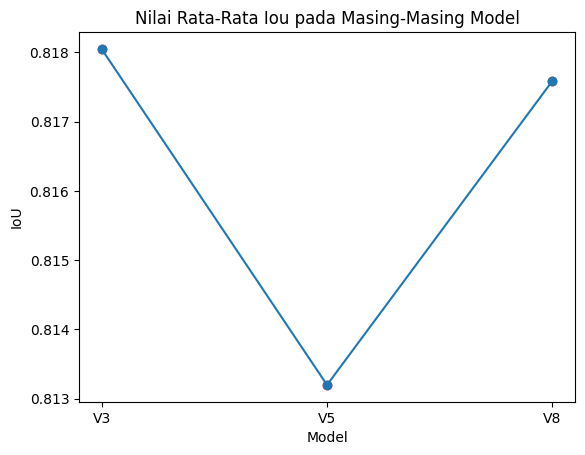

In [ ]:
#membuat grafik pengolahan data
import matplotlib.pyplot as plt

# Data pada sumbu x dan y
x = ['V3', 'V5', 'V8']
y = [0.81805, 0.8132, 0.81759]

# Membuat grafik garis
plt.plot(x, y, marker='o', linestyle='-')

# Menambahkan titik pada data
plt.scatter(x, y, color='red')

# Menambahkan judul dan label sumbu
plt.title('Nilai Rata-Rata Iou pada Masing-Masing Model')
plt.xlabel('Model')
plt.ylabel('IoU')

# Menampilkan grafik
plt.show()



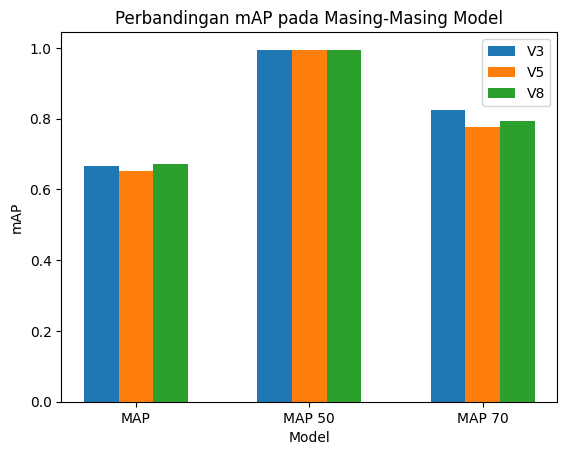

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data
categories = ["MAP", "MAP 50", "MAP 70"]
models = ["V3", "V5", "V8"]
values = np.array([
    [0.667702045, 0.995, 0.8254446],
    [0.652488603, 0.995, 0.776276262],
    [0.672349717, 0.995, 0.792211894]
])

# Plotting
x = np.arange(len(categories))
width = 0.2

fig, ax = plt.subplots()
for i in range(len(models)):
    ax.bar(x + i * width, values[i], width, label=models[i])

# Menambahkan judul dan label sumbu
ax.set_title('Perbandingan mAP pada Masing-Masing Model')
ax.set_xticks(x + width * (len(models) - 1) / 2)
ax.set_xticklabels(categories)
ax.set_xlabel('Model')
ax.set_ylabel('mAP')
ax.legend()

# Menampilkan grafik
plt.show()
